<a href="https://colab.research.google.com/github/james-hughes1/uk-climate-project/blob/main/Wildfire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction

This is the second project related to the UK heatwave in the summer of 2022. For the GitHub repository of the first project click [here](https://github.com/james-hughes1/UK-Drought-Project). In this Google Colab notebook, I use a [kaggle dataset](https://www.kaggle.com/datasets/brsdincer/wildfire-detection-image-data) to train a deep neural network model to detect whether or not there is a wildfire in an image of a natural landscape. My aim is to provide an example of how machine learning can add value to the process of adapting to climate change - in this instance, such an algorithm could be feed real-time imagery from cameras overlooking fields and forests across the UK, and transmit an alert warning to local authorities once a wildfire is detected.

## Load Dataset & Libraries

In [2]:
import tensorflow as tf
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import shutil

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download brsdincer/wildfire-detection-image-data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 76% 19.0M/24.9M [00:00<00:00, 53.9MB/s]
100% 24.9M/24.9M [00:00<00:00, 57.9MB/s]


## Organise Files

In [4]:
local_zip = '/content/wildfire-detection-image-data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
source_dir = 'forest_fire'

training_dir = os.path.join(source_dir, 'Training and Validation')
training_dir_fire = os.path.join(training_dir, 'fire')
training_dir_nofire = os.path.join(training_dir, 'nofire')

validation_dir = os.path.join(source_dir, 'Testing')
validation_dir_fire = os.path.join(validation_dir, 'fire')
validation_dir_nofire = os.path.join(validation_dir, 'nofire')

for rootdir, dirs, _ in os.walk(source_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

forest_fire/Training and Validation
forest_fire/Testing
forest_fire/Training and Validation/nofire
forest_fire/Training and Validation/fire
forest_fire/Testing/nofire
forest_fire/Testing/fire


## Exploring the Data

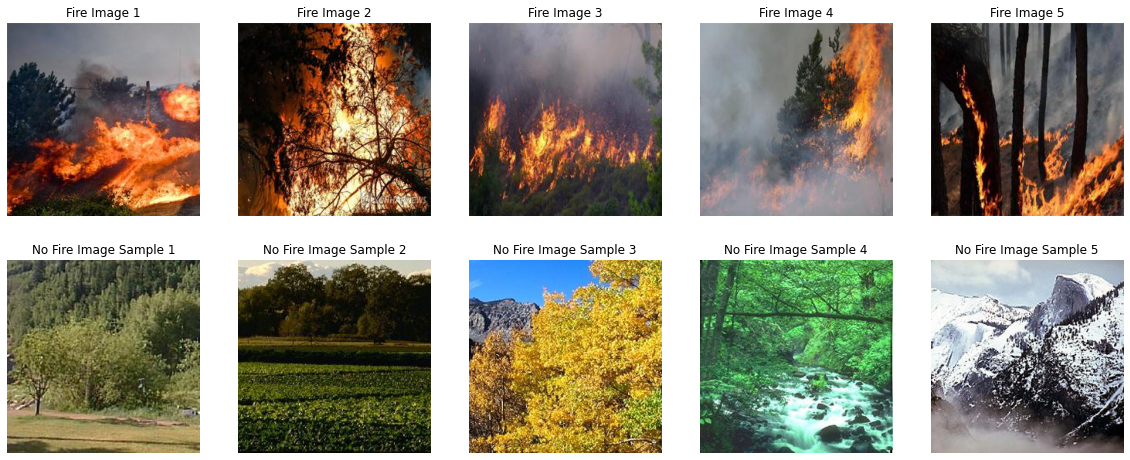

In [6]:
photo_dirs = random.sample(os.listdir(training_dir_fire),5) + random.sample(os.listdir(training_dir_nofire),5)
plt.figure(figsize=(20,8))
for i, dir in enumerate(photo_dirs):
  plt.subplot(2, 5, i+1)
  plt.axis('off')
  if i < 5:
    plt.title('Fire Image '+str(i+1))
    plt.imshow(mpimg.imread(os.path.join(training_dir_fire, dir)))
  else:
    plt.title('No Fire Image Sample '+str(i-4))
    plt.imshow(mpimg.imread(os.path.join(training_dir_nofire, dir)))

Inspecting some samples of the images in the dataset, we can see that we have a wide variety of images depicting wildfires, and then 'no fire' images depicting of various natural landscapes. Perhaps the biggest drawback of this dataset is that there are clearly quite a few images which do not represent the UK landscape very well, especially the numerous images of snowy mountains.

##Data Engineering (Image Augmentation)

Implementing augmentation with the image generators is a way to prevent overfitting, especially with our limited dataset. I have tried to only include augmentations which would transform the training images into 'simulated' images that could have been taken from an upright camera in the natural landscape.

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   brightness_range = (0.5,1.0),
                                   fill_mode = 'reflect')

train_generator = train_datagen.flow_from_directory(training_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=20,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 1832 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


## Baseline Model


Given the samples of the images above, the below model seemed to provide a suitable baseline. In particular, it addresses the immediate concern that we could just classify an image as a wildfire - or not - purely based on the average pixel colour of the image, in particular the average amount of 'red' in the pixel values. If the more sophisticated deep learning approaches cannot outperform this then the computational resources required to build them cannot be justified.

In [39]:
model_base = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(input_shape=(150,150,3)),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model_base.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_base = model_base.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/20
92/92 [==============================] - 45s 489ms/step - loss: 0.7157 - accuracy: 0.4902 - val_loss: 0.7515 - val_accuracy: 0.3088
Epoch 2/20
92/92 [==============================] - 13s 141ms/step - loss: 0.7088 - accuracy: 0.4640 - val_loss: 0.7349 - val_accuracy: 0.3088
Epoch 3/20
92/92 [==============================] - 13s 143ms/step - loss: 0.7035 - accuracy: 0.4258 - val_loss: 0.7206 - val_accuracy: 0.2500
Epoch 4/20
92/92 [==============================] - 13s 142ms/step - loss: 0.6982 - accuracy: 0.3996 - val_loss: 0.7100 - val_accuracy: 0.2941
Epoch 5/20
92/92 [==============================] - 13s 142ms/step - loss: 0.6933 - accuracy: 0.5022 - val_loss: 0.7005 - val_accuracy: 0.3971
Epoch 6/20
92/92 [==============================] - 14s 148ms/step - loss: 0.6882 - accuracy: 0.6152 - val_loss: 0.6924 - val_accuracy: 0.5735
Epoch 7/20
92/92 [==============================] - 13s 142ms/step - loss: 0.6837 - accuracy: 0.6507 - val_loss: 0.6844 - val_accuracy: 0.7206

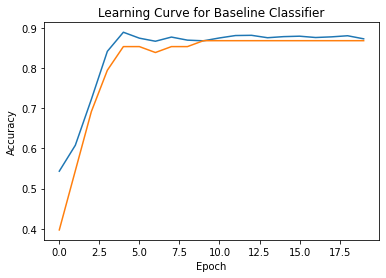

In [9]:
plt.plot(history_base.history['accuracy'], label='Training')
plt.plot(history_base.history['val_accuracy'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Baseline Classifier')
plt.show()

## Convolutional Neural Networks

### Basic Model

The baseline classifier actually performed very well at around 80% validationa accuracy. But there is reason to believe we can achieve better with a more sophisticated approach such as convolutional neural networks. For instance, some of the images of wildfire don't have a lot of red pixels in them at all if they mainly depict a lot of smoke.

In [14]:
model_cnn1 = tf.keras.Sequential([
    tf.keras.layers.Convolution2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [38]:
model_cnn1.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_cnn1 = model_cnn1.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/20
92/92 [==============================] - 15s 155ms/step - loss: 0.1130 - accuracy: 0.9640 - val_loss: 0.4365 - val_accuracy: 0.9265
Epoch 2/20
92/92 [==============================] - 15s 165ms/step - loss: 0.1153 - accuracy: 0.9683 - val_loss: 0.4405 - val_accuracy: 0.9265
Epoch 3/20
92/92 [==============================] - 19s 204ms/step - loss: 0.1068 - accuracy: 0.9656 - val_loss: 0.4053 - val_accuracy: 0.9265
Epoch 4/20
92/92 [==============================] - 14s 150ms/step - loss: 0.1255 - accuracy: 0.9607 - val_loss: 0.3783 - val_accuracy: 0.9412
Epoch 5/20
92/92 [==============================] - 14s 150ms/step - loss: 0.1230 - accuracy: 0.9623 - val_loss: 0.2513 - val_accuracy: 0.9265
Epoch 6/20
92/92 [==============================] - 15s 159ms/step - loss: 0.1150 - accuracy: 0.9651 - val_loss: 0.3581 - val_accuracy: 0.9559
Epoch 7/20
92/92 [==============================] - 14s 149ms/step - loss: 0.1155 - accuracy: 0.9651 - val_loss: 0.3168 - val_accuracy: 0.9118

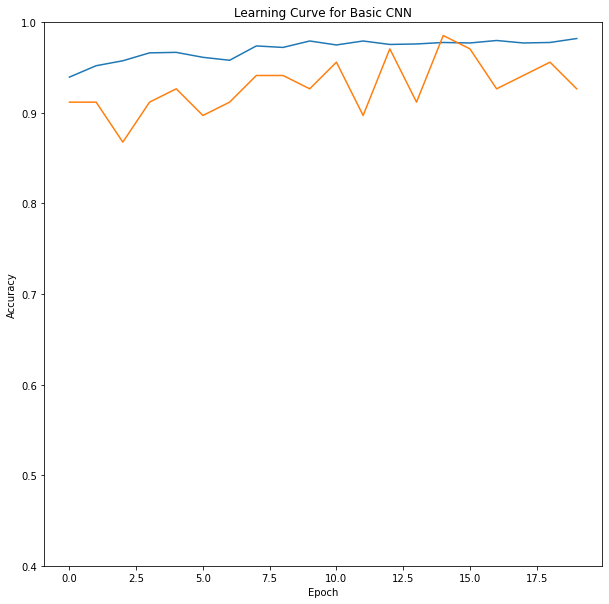

In [40]:
plt.figure(figsize=(10,5))

plt.plot(history_cnn1.history['accuracy'], label='Training')
plt.plot(history_cnn1.history['val_accuracy'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0.4,1.0))
plt.title('Learning Curve for Basic CNN')

plt.show()

### Advanced Model

In [18]:
model_cnn2 = tf.keras.Sequential([
    tf.keras.layers.Convolution2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Convolution2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Convolution2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [20]:
model_cnn2.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_cnn2 = model_cnn2.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/20
92/92 [==============================] - 16s 168ms/step - loss: 0.1660 - accuracy: 0.9394 - val_loss: 0.2126 - val_accuracy: 0.9118
Epoch 2/20
92/92 [==============================] - 13s 145ms/step - loss: 0.1465 - accuracy: 0.9520 - val_loss: 0.2108 - val_accuracy: 0.9118
Epoch 3/20
92/92 [==============================] - 14s 150ms/step - loss: 0.1290 - accuracy: 0.9574 - val_loss: 0.2614 - val_accuracy: 0.8676
Epoch 4/20
92/92 [==============================] - 14s 154ms/step - loss: 0.1041 - accuracy: 0.9662 - val_loss: 0.2540 - val_accuracy: 0.9118
Epoch 5/20
92/92 [==============================] - 17s 189ms/step - loss: 0.1022 - accuracy: 0.9667 - val_loss: 0.1942 - val_accuracy: 0.9265
Epoch 6/20
92/92 [==============================] - 18s 192ms/step - loss: 0.1094 - accuracy: 0.9612 - val_loss: 0.3149 - val_accuracy: 0.8971
Epoch 7/20
92/92 [==============================] - 13s 144ms/step - loss: 0.1175 - accuracy: 0.9580 - val_loss: 0.2182 - val_accuracy: 0.9118

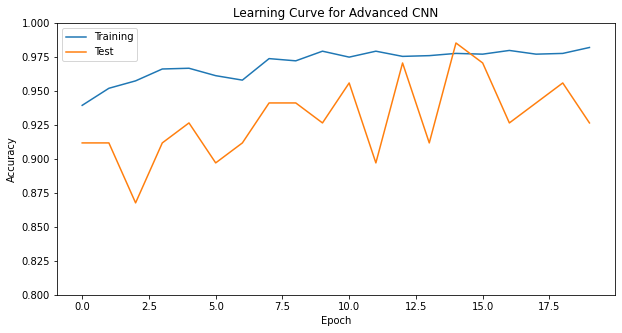

In [25]:
plt.figure(figsize=(10,5))

plt.plot(history_cnn2.history['accuracy'], label='Training')
plt.plot(history_cnn2.history['val_accuracy'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0.8,1.0))
plt.title('Learning Curve for Advanced CNN')

plt.show()

### Adding a Dropout Layer

In [28]:
model_cnn3 = tf.keras.Sequential([
    tf.keras.layers.Convolution2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Convolution2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Convolution2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [29]:
model_cnn3.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_cnn3 = model_cnn3.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/20
92/92 [==============================] - 16s 171ms/step - loss: 0.2679 - accuracy: 0.9072 - val_loss: 0.3735 - val_accuracy: 0.9118
Epoch 2/20
92/92 [==============================] - 13s 144ms/step - loss: 0.1635 - accuracy: 0.9438 - val_loss: 0.3196 - val_accuracy: 0.8971
Epoch 3/20
92/92 [==============================] - 13s 145ms/step - loss: 0.1384 - accuracy: 0.9525 - val_loss: 0.3931 - val_accuracy: 0.8676
Epoch 4/20
92/92 [==============================] - 13s 145ms/step - loss: 0.1474 - accuracy: 0.9487 - val_loss: 0.3044 - val_accuracy: 0.9118
Epoch 5/20
92/92 [==============================] - 14s 148ms/step - loss: 0.1198 - accuracy: 0.9580 - val_loss: 0.2089 - val_accuracy: 0.9265
Epoch 6/20
92/92 [==============================] - 13s 145ms/step - loss: 0.1020 - accuracy: 0.9645 - val_loss: 0.2040 - val_accuracy: 0.8971
Epoch 7/20
92/92 [==============================] - 13s 144ms/step - loss: 0.1021 - accuracy: 0.9662 - val_loss: 0.1922 - val_accuracy: 0.8824

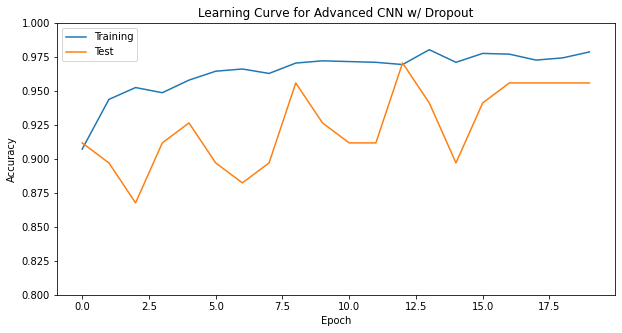

In [30]:
plt.figure(figsize=(10,5))

plt.plot(history_cnn3.history['accuracy'], label='Training')
plt.plot(history_cnn3.history['val_accuracy'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0.8,1.0))
plt.title('Learning Curve for Advanced CNN w/ Dropout')

plt.show()

### Comparing The Models

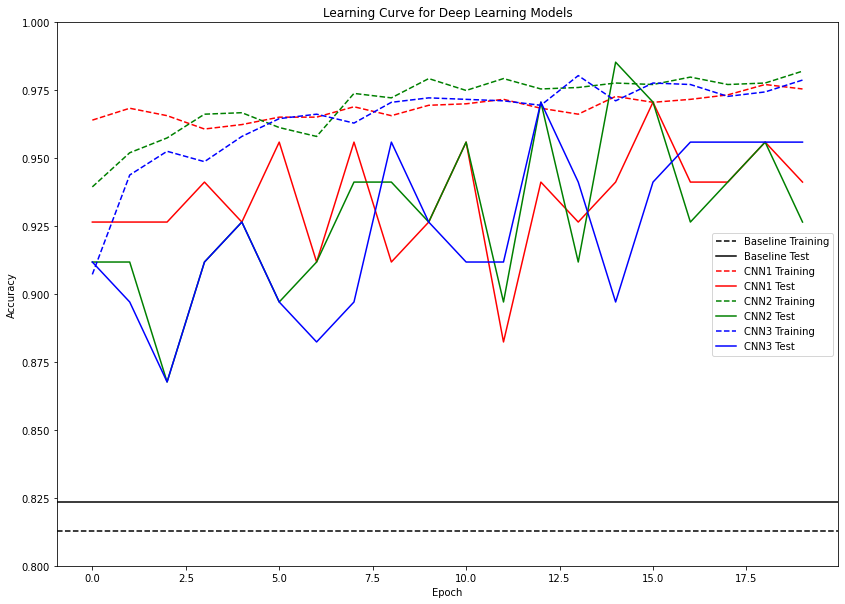

In [51]:
plt.figure(figsize=(14,10))

plt.axhline(history_base.history['accuracy'][-1], label='Baseline Training', color='black', linestyle='dashed')
plt.axhline(history_base.history['val_accuracy'][-1], label='Baseline Test', color='black')
plt.plot(history_cnn1.history['accuracy'], label='CNN1 Training', color='red', linestyle='dashed')
plt.plot(history_cnn1.history['val_accuracy'], label='CNN1 Test', color='red')
plt.plot(history_cnn2.history['accuracy'], label='CNN2 Training', color='green', linestyle='dashed')
plt.plot(history_cnn2.history['val_accuracy'], label='CNN2 Test', color='green')
plt.plot(history_cnn3.history['accuracy'], label='CNN3 Training', color='blue', linestyle='dashed')
plt.plot(history_cnn3.history['val_accuracy'], label='CNN3 Test', color='blue')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0.8,1.0))
plt.title('Learning Curve for Deep Learning Models')

plt.show()

## Analyse External Images

This can allow us to inspect the way in which the model processes our own custom images of natural landscapes, and consider edge cases.

Saving smoke.jpg to smoke.jpg
[0.82889885]
smoke.jpg has no fire


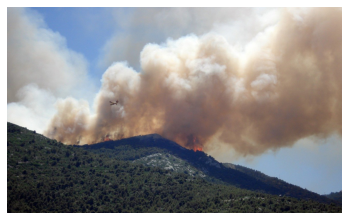

In [20]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))

  plt.axis('off')
  plt.imshow(mpimg.imread(path))

  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_cnn.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " has no fire")
  else:
    print(fn + " has a fire")